In [1]:
!git clone https://github.com/microsoft/AdversarialGMM.git

Cloning into 'AdversarialGMM'...
remote: Enumerating objects: 178, done.
remote: Counting objects: 100% (178/178), done.
remote: Compressing objects: 100% (138/138), done.
remote: Total 178 (delta 42), reused 152 (delta 32), pack-reused 0
Receiving objects: 100% (178/178), 4.93 MiB | 9.96 MiB/s, done.
Resolving deltas: 100% (42/42), done.


In [1]:
### Magic functinos
%load_ext autoreload
%autoreload 2
%load_ext tensorboard
%matplotlib inline

In [2]:
import warnings
warnings.simplefilter('ignore')
import itertools
import numpy as np
import matplotlib.pyplot as plt 
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from mliv.dgps import get_data, get_tau_fn, fn_dict
from mliv.neuralnet.utilities import log_metrics, plot_results
from mliv.neuralnet.rbflayer import gaussian, inverse_multiquadric
from mliv.neuralnet import AReisz
from mliv.neuralnet import AGMM, KernelLayerMMDGMM, CentroidMMDGMM, KernelLossAGMM, MMDGMM

In [3]:
n = 100000
n_z = 3
n_t = 3
iv_strength = .6
fname = 'abs'
dgp_num = 5
Z, T, Y, true_fn, ystd, ym = get_data(n, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)

In [4]:
ind = 0
x_grid = np.linspace(np.quantile(T[:, ind], .01), np.quantile(T[:, ind], .99), 100)
T_test = np.zeros((100, T.shape[1])) + np.median(T, axis=0, keepdims=True)
T_test[:, 0] = x_grid


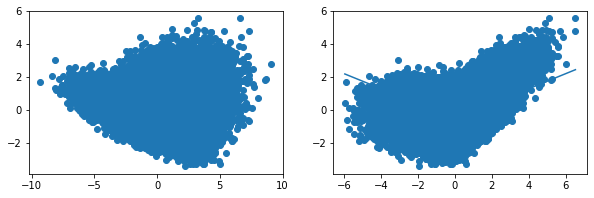

In [5]:
plt.figure(figsize=(10,3))
plt.subplot(1, 2, 1)
plt.scatter(Z[:, 0], Y)
plt.subplot(1, 2, 2)
plt.scatter(T[:, 0], Y)
plt.plot(T[np.argsort(T[:, 0]), 0], true_fn((T[np.argsort(T[:, 0])])))
plt.show()

In [6]:
p = 0.1 # dropout prob of dropout layers throughout notebook
n_hidden = 100 # width of hidden layers throughout notebook

learner = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                        nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                        nn.Dropout(p=p), nn.Linear(n_hidden, 1))

In [7]:
# For any method that use a projection of z into features g(z)
g_features = 100
adversary_g = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, g_features), nn.ReLU())
# The kernel function
kernel_fn = gaussian
# kernel_fn = inverse_multiquadric

# For any method that uses an unstructured adversary test function f(z)
adversary_fn = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                             #nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                             nn.Dropout(p=p), nn.Linear(n_hidden, 1))

In [8]:
learner_lr = 1e-4
adversary_lr = 1e-4
learner_l2 = 1e-3
adversary_l2 = 1e-4
adversary_norm_reg = 1e-3
n_epochs = 300
bs = 100
sigma = 2.0/g_features
n_centers = 100
device = torch.cuda.current_device() if torch.cuda.is_available() else None

In [9]:
if torch.cuda.is_available():
    torch.cuda.empty_cache()
Z_train, Z_val, T_train, T_val, Y_train, Y_val = train_test_split(Z, T, Y, test_size=.1, shuffle=True)
Z_train, T_train, Y_train = map(lambda x: torch.Tensor(x), (Z_train, T_train, Y_train))
Z_val, T_val, Y_val = map(lambda x: torch.Tensor(x).to(device), (Z_val, T_val, Y_val))
G_train = true_fn(T_train)
G_val = true_fn(T_val.cpu())
G_train, G_val = map(lambda x: x.to(device), (G_train,G_val))
T_test_tens = torch.Tensor(T_test).to(device)
G_test_tens = true_fn(T_test_tens.cpu()).to(device)

In [10]:
T_0 = T_train.clone()
T_1 = T_train.clone()
T_1[:,0] =   1 + ( T_1[:,0])
point_before = true_fn(T_0).flatten()
point_after =  true_fn(T_1).flatten()
true = torch.mean(point_after - point_before)*ystd
print(true)

tensor(0.2706)


In [11]:
def estimateGMM(Z, T, Y, n_epochs=1000):
    
    agmm = AGMM(learner, adversary_fn).fit(Z, T, Y, learner_lr=learner_lr, adversary_lr=adversary_lr,
                                       learner_l2=learner_l2, adversary_l2=adversary_l2,
                                       n_epochs=n_epochs, bs=bs, logger=None,
                                       model_dir='agmm_model', device=device)

    return agmm

In [12]:

def moment_func_agmm(learner, xb):
    xb_1 = xb.clone()
    xb_1[:,0] =   1 + xb[:,0]
    point_0 = learner.predict(xb.to(device), model='final')
    point_1 = learner.predict(xb_1.to(device), model='final')
    return point_1 - point_0

In [13]:
def estimateReisz(Z, T, Y, moment_func, n_epochs=1000):
    p = 0.1 # dropout prob of dropout layers throughout notebook
    n_hidden = 100 # width of hidden layers throughout notebook

    learner_reisz = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                        #nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                        nn.Dropout(p=p), nn.Linear(n_hidden, 1))


    # For any method that uses an unstructured adversary test function f(z)
    adversary_fn_reisz = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                             #nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                             nn.Dropout(p=p), nn.Linear(n_hidden, 1))
    
    areisz = AReisz(learner_reisz, adversary_fn_reisz).fit(Z, T, Y, moment_func = moment_func, 
                                                       learner_lr=learner_lr, adversary_lr=adversary_lr,
                                       learner_l2=learner_l2, adversary_l2=adversary_l2,
                                       n_epochs=n_epochs, bs=bs, logger=None,
                                       model_dir='areisz_model', device=device)
    return areisz

In [ ]:
def logger(learner, adversary, epoch, writer):
    writer.add_histogram('learner', learner[-1].weight, epoch)
    writer.add_histogram('adversary', adversary[-1].weight, epoch)
    log_metrics(Z_val, T_val, Y_val, Z_val, T_val, Y_val, T_test_tens,
                learner, adversary, epoch, writer, true_of_T=G_val)

np.random.seed(12356)
#agmm = AGMM(learner, adversary_fn).fit(Z_train, T_train, Y_train, learner_lr=learner_lr, adversary_lr=adversary_lr,
#                                       learner_l2=learner_l2, adversary_l2=adversary_l2,
#                                    n_epochs=1000, bs=bs, logger=None,
#                                       model_dir='agmm_model', device=device)
agmm = estimateGMM(Z_train, T_train, Y_train)


None


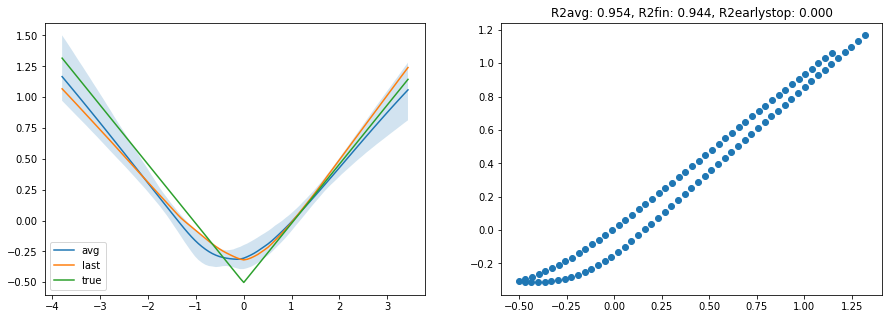

MSEavg 0.012052801
MSEfin 0.014443405


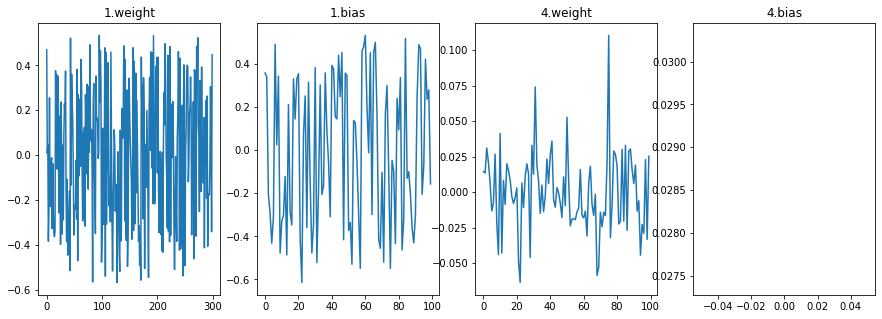

In [46]:
plot_results(agmm, T_test_tens, G_test_tens, ind=0)

In [14]:
def compute_theta_V(Z, T, Y, agmm, areisz, ystd, moment_func_agmm):
    theta = torch.mean(np.multiply(areisz.predict(Z.to(device), model='final').flatten(), 
                           (Y.cpu()-agmm.predict(T.to(device) , model='final') ).flatten())*ystd  + moment_func_agmm(agmm, T).flatten()*ystd)
    psi = (np.multiply(areisz.predict(Z.to(device), model='final').flatten(), 
                           (Y.cpu()-agmm.predict(T.to(device), model='final')).flatten())*ystd  + moment_func_agmm(agmm, T).flatten()*ystd - theta)**2
    V = torch.mean(psi)
    return theta, V


In [15]:
def runCrossFitDCR(n=1000, fname='abs'):
    n_z = 3
    n_t = 3
    iv_strength = .6
    dgp_num = 5
    Z_1, T_1, Y_1, true_fn, ystd_1, ym_1 = get_data(n, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
    Z_2, T_2, Y_2, true_fn, ystd_2, ym_2 = get_data(n, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)

    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    Z_1, Z_2, T_1, T_2, Y_1, Y_2 = map(lambda x: torch.Tensor(x), (Z_1, Z_2, T_1, T_2, Y_1, Y_2))
    def moment_func(adversary, xb):
        xb_1 = xb.clone()
        xb_1[:,0] =   1 + xb[:,0]
        point_0 = adversary(xb)
        point_1 = adversary(xb_1)
        return point_1 - point_0
    def moment_func_agmm(learner, xb):
        xb_1 = xb.clone()
        xb_1[:,0] =   1 + xb[:,0]
        point_0 = learner.predict(xb.to(device), model='final')
        point_1 = learner.predict(xb_1.to(device), model='final')
        return point_1 - point_0
    
    agmm_1    = estimateGMM(Z_1, T_1, Y_1)
    areisz_1  = estimateReisz(Z_1, T_1, Y_1, moment_func = moment_func)
    theta_1, V_1   = compute_theta_V(Z_2, T_2, Y_2, agmm_1, areisz_1, ystd_1, moment_func_agmm=moment_func_agmm) 
    agmm_2    = estimateGMM(Z_2, T_2, Y_2)
    areisz_2  = estimateReisz(Z_2, T_2, Y_2, moment_func = moment_func)
    theta_2, V_2   = compute_theta_V(Z_1, T_1, Y_1, agmm_2, areisz_2, ystd_2, moment_func_agmm=moment_func_agmm)
    theta = (theta_1+theta_2)/2
    V     = (V_1 + V_2)/2
    return theta, V
    

In [16]:
counter = 0
thetas = []
print(true)
for i in range(30):
    theta,V = runCrossFitDCR(fname=fname)
    print(theta)
    thetas.append(theta)
    se = np.sqrt(V)/np.sqrt(2000)
    if true > theta - 1.96*se and true < theta+1.96*se:
        counter +=1
        print(counter)

tensor(0.2706)
tensor(0.3774)
1
tensor(0.3240)
2
tensor(0.3350)
3
tensor(0.3037)
4
tensor(0.1940)
5
tensor(0.3190)
6


KeyboardInterrupt: 

In [31]:
print(torch.__version__)

1.12.0+cu116


In [19]:
np.mean([theta - true for theta in thetas])

-0.006206373

In [17]:
np.mean([(theta - true)**2 for theta in thetas])

0.0017706641

In [ ]:
1.96*np.sqrt(5.5816)/np.sqrt(2000)

In [14]:
T_test_tens_final = T_train.clone()
T_test_tens_final[:,0] =   1 + ( T_train[:,0])

In [15]:
point_before = agmm.predict(T_train.to(device), model='final')
point_after = agmm.predict(T_test_tens_final.to(device), model='final')

NameError: name 'agmm' is not defined

In [103]:
np.mean(point_after - point_before)*ystd

0.8827910116917589

In [37]:
np.sign(0-.5)

-1.0

In [189]:
p = 0.1 # dropout prob of dropout layers throughout notebook
n_hidden = 100 # width of hidden layers throughout notebook

learner_reisz = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_t, n_hidden), nn.LeakyReLU(),
                        #nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                        nn.Dropout(p=p), nn.Linear(n_hidden, 1))
# For any method that use a projection of z into features g(z)
g_features = 100
adversary_g_reisz = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                            nn.Dropout(p=p), nn.Linear(n_hidden, g_features), nn.ReLU())
# The kernel function
kernel_fn_reisz = gaussian
# kernel_fn = inverse_multiquadric

# For any method that uses an unstructured adversary test function f(z)
adversary_fn_reisz = nn.Sequential(nn.Dropout(p=p), nn.Linear(n_z, n_hidden), nn.LeakyReLU(),
                             #nn.Dropout(p=p), nn.Linear(n_hidden, n_hidden), nn.ReLU(),
                             nn.Dropout(p=p), nn.Linear(n_hidden, 1))

In [190]:
def logger(learner, adversary, epoch, writer):
    writer.add_histogram('learner', learner[-1].weight, epoch)
    writer.add_histogram('adversary', adversary[-1].weight, epoch)
    log_metrics(Z_val, T_val, Y_val, Z_val, T_val, Y_val, T_test_tens,
                learner, adversary, epoch, writer, true_of_T=G_val)

np.random.seed(12356)
def moment_func(adversary, xb):
    xb_1 = xb.clone()
    xb_1[:,0] =   1 + xb[:,0]
    point_0 = adversary(xb)
    point_1 = adversary(xb_1)
    return point_1 - point_0

In [ ]:
    

    
areisz = AReisz(learner_reisz, adversary_fn_reisz).fit(Z_train, T_train, Y_train, moment_func = moment_func, 
                                                       learner_lr=learner_lr, adversary_lr=adversary_lr,
                                       learner_l2=learner_l2, adversary_l2=adversary_l2,
                                       n_epochs=1000, bs=bs, logger=logger,
                                       model_dir='areisz_model', device=device)

In [191]:
areisz = estimateReisz(Z_train, T_train, Y_train, moment_func = moment_func)

In [193]:
counter = 0
for i in range(1,100):
    n = 1000
    n_z = 3
    n_t = 3
    iv_strength = .6
    fname = 'abs'
    dgp_num = 5
    Z, T, Y, true_fn, ystd, ym = get_data(n, n_z, iv_strength, get_tau_fn(fn_dict[fname]), dgp_num)
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    Z_train, Z_val, T_train, T_val, Y_train, Y_val = train_test_split(Z, T, Y, test_size=.1, shuffle=True)
    Z_train, T_train, Y_train = map(lambda x: torch.Tensor(x), (Z_train, T_train, Y_train))
    Z_val, T_val, Y_val = map(lambda x: torch.Tensor(x).to(device), (Z_val, T_val, Y_val))
    G_train = true_fn(T_train)
    G_val = true_fn(T_val.cpu())
    G_train, G_val = map(lambda x: x.to(device), (G_train,G_val))
    T_test_tens = torch.Tensor(T_test).to(device)
    G_test_tens = true_fn(T_test_tens.cpu()).to(device)
    theta = torch.mean(np.multiply(areisz.predict(Z_train.to(device), model='final').flatten(), 
                           (Y_train.cpu()-agmm.predict(T_train.to(device) , model='final') ).flatten())*ystd  + moment_func_agmm(agmm, T_train).flatten()*ystd)
    print(theta)
    psi = (np.multiply(areisz.predict(Z_train.to(device), model='final').flatten(), 
                           (Y_train.cpu()-agmm.predict(T_train.to(device), model='final')).flatten())*ystd  + moment_func_agmm(agmm, T_train).flatten()*ystd - theta)**2
    V = torch.mean(psi)
    se = np.sqrt(V)
    if 0.26 > theta - 1.96*se/np.sqrt(1000) and 0.26 < theta+1.96*se/np.sqrt(1000):
        counter +=1
        print(counter)
        


tensor(0.2867)
1
tensor(0.2736)
2
tensor(0.3058)
3
tensor(0.2958)
4
tensor(0.2607)
5
tensor(0.3518)
6
tensor(0.2559)
7
tensor(0.2529)
8
tensor(0.2349)
9
tensor(0.3913)
tensor(0.2693)
10
tensor(0.2566)
11
tensor(0.2766)
12
tensor(0.2735)
13
tensor(0.3242)
14
tensor(0.3169)
15
tensor(0.2718)
16
tensor(0.2714)
17
tensor(0.2576)
18
tensor(0.2522)
19
tensor(0.2778)
20
tensor(0.3481)
21
tensor(0.1971)
22
tensor(0.2181)
23
tensor(0.2977)
24
tensor(0.1733)
25
tensor(0.2716)
26
tensor(0.3475)
27
tensor(0.2727)
28
tensor(0.2922)
29
tensor(0.2035)
30
tensor(0.3403)
31
tensor(0.2661)
32
tensor(0.1942)
33
tensor(0.2877)
34
tensor(0.2541)
35
tensor(0.2337)
36
tensor(0.2785)
37
tensor(0.2603)
38
tensor(0.2899)
39
tensor(0.3630)
40
tensor(0.2227)
41
tensor(0.1993)
42
tensor(0.1941)
43
tensor(0.3066)
44
tensor(0.1943)
45
tensor(0.2763)
46
tensor(0.3369)
47
tensor(0.4508)
tensor(0.4031)
48
tensor(0.2254)
49
tensor(0.3075)
50
tensor(0.1767)
51
tensor(0.4071)
tensor(0.1730)
52
tensor(0.2476)
53
tensor(0.2

In [229]:
print(theta)

tensor(-0.0195)


In [232]:
theta - 1.96*se/np.sqrt(1000), theta+1.96*se/np.sqrt(1000)

(tensor(-0.1135), tensor(0.0745))